## Exploration of Basic Feedforward Neural Network From Scratch

---

### Project Overview

This ipynb file ultimately aims to build a fully custom feedforward neural network framework using Python and NumPy, which will be accomplished namely by:

1. Implementing core components such as neurons, layers, activation functions, loss functions, and an optimiser
2. Demonstrating training on sample datasets, visualise performance, and compare results against a baseline
3. Exploring advanced features like different optimisers, and potential more compairsons between different architectures

---
## Table of Contents
---
##### 1. Imports and Setup
##### 2. Activation and Derivatives
##### $~~~~~$ 2.1 Sigmoid
##### $~~~~~$ 2.2 ReLu
##### 3. Loss Functions
##### $~~~~~$ 3.1 Mean Squared Error(MSE)
##### $~~~~~$ 3.2 Binary Cross Entropy(BCE)
##### 4. Optimisers from Scratch
##### $~~~~~$ 4.1 Stochastic Gradient Descent (no momentum)
##### $~~~~~$ 4.2 Stochastic Gradient Descent (with momentum)
##### $~~~~~$ 4.3 Adam
##### 5. Feedforward Network Implementations
##### $~~~~~$ 5.1 ElementWiseFFN: Manual "per-neuron" approach
##### $~~~~~$ 5.2 MatrixFFN: 2-layer network (hidden + output) with matrices
##### $~~~~~$ 5.3 MultiLayerFFN: Arbitrary multi-layer (fully connected) NN
##### 6. Data Generation
##### $~~~~~$ 6.1 Linearly Separable Data
##### $~~~~~$ 6.2 "Two Moons" Data
##### $~~~~~$ 6.3 Interleaved Spirals
##### 7. Training Demonstration
##### $~~~~~$ 7.1 Training for Elementwise FFN
##### $~~~~~$ 7.2 Training for MatrixFFN
##### $~~~~~$ 7.3 Training for MultiLayerFFN
##### 8. Main Execution
##### $~~~~~$ 8.1 Comparison for Linearly Separable Data
##### $~~~~~$ 8.2 Comparison for Two Moons Data
##### $~~~~~$ 8.3 Comparison for Interleaved Spirals Data
##### $~~~~~$ 8.4 Final Comparison
##### 9. Summary
##### $~~~~~$ 9.1 Dataset Difficulty
##### $~~~~~$ 9.2 Loss Functions Comparison
##### $~~~~~$ 9.3 Activation Functions Comparison
##### $~~~~~$ 9.4 Optimisers Comparison
---

## 1. Imports and Setup

Below, we load the necessary Python libraries for matrix operations, plotting, and performance tracking

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import logging
import copy
from typing import List, Tuple, Dict, Union

np.random.seed(42)

## 2. Activation and Derivatives

#### 2.1 Sigmoid
First we try the sigmoid function, chosen for its smooth gradient, which is useful in binary classification:  


Sigmoid Equation:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Sigmoid Derivative x:
$$
\sigma'(x) = \sigma(x)\left(1 - \sigma(x)\right)
$$

Code for Sigmoid:

In [12]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_deriv(x: np.ndarray) -> np.ndarray:
    s = sigmoid(x)
    return s * (1.0 - s)

#### 2.2 ReLu
Then we also try ReLU (Rectified Linear Unit), which is favoured for its simplicity and to mitigate vanishing gradient issues in deep networks:  

ReLu Equation:
$$
\text{ReLU}(x) = \max(0, x)
$$
ReLu Derivative:
$$
\text{ReLU}'(x) =
\begin{cases}
1, & \text{if } x > 0, \\
0, & \text{otherwise}.
\end{cases}
$$

Code for ReLu:

In [16]:
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

def relu_deriv(x: np.ndarray) -> np.ndarray:
    grad = np.zeros_like(x)
    grad[x > 0] = 1
    return grad

## 3. Loss Functions

#### 3.1 Mean Sqaured Error(MSE)
For loss functions, we can start with Mean Squared Error(MSE) which although is more common in regression, it’s implemented for demonstration:

MSE Equation:
$$
\text{MSE}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Code for above MSE equations:

In [21]:
def mse_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred)**2)

def mse_deriv(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return -2.0 * (y_true - y_pred) / y_true.shape[0]

---
#### 3.2 Binary Cross Entropy(BCE)
We can also experiment with Binary Cross Entropy(BCE) which is typically preferred for binary classification tasks:

BCE Equation:
$$
\text{BCE}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]
$$

Code for above BCE equations:

In [25]:
def binary_cross_entropy_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1.0 - y_pred))

def binary_cross_entropy_deriv(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return ((-y_true / y_pred) + ((1.0 - y_true) / (1.0 - y_pred))) / y_true.shape[0]

## 4. Optimisers from Scratch

Class for optimiser:

In [28]:
class OptimiserBase:
    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        raise NotImplementedError("step method must be implemented by subclass optimisers.")

---
#### 4.1 Stochastic Gradient Descent (no momentum)
We can start off with the basic baseline optimiser, Stochastic Gradient Descent(SGD) which is simple and intuitive:

SGD Update Rule:
$$
\theta = \theta - \eta \nabla L(\theta)
$$

Code for SGD:

In [32]:
class SGD(OptimiserBase):
    """
    Attributes:
        lr (float): Learning rate.
    """
    def __init__(self, lr: float = 0.01):
        self.lr = lr

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        for p, g in zip(params, grads):
            p -= self.lr * g

---

#### 4.2 Stochastic Gradient Descent (with momentum)
We can take it one step further an try SGD with Momentum, which helps to smooth out the updates and accelerate training:

SGD with Momentum Update Rule:
$$
\begin{aligned}
v &= \mu v - \eta \nabla L(\theta), \\
\theta &= \theta + v.
\end{aligned}
$$

Code for SGD with Momentum:

In [37]:
class SGDWithMomentum(OptimiserBase):
    """
    Attributes:
        lr (float): Learning rate.
        momentum (float)
    """
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]

        for i, (p, g) in enumerate(zip(params, grads)):
            self.v[i] = self.momentum * self.v[i] - self.lr * g
            p += self.v[i]

---

#### 4.3 Adam

Lastly we can experiment with Adam Optimiser, which essentially combines momentum and adaptive learning rates:

Key Equations for Adam Optimiser:
$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) \nabla L(\theta), \\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) \left(\nabla L(\theta)\right)^2, \\
\hat{m}_t &= \frac{m_t}{\,1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{\,1-\beta_2^t}, \\
\theta &= \theta - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}.
\end{aligned}
$$

Code for Adam Optimiser:

In [43]:
class Adam(OptimiserBase):
    """
    Attributes:
        lr (float): Learning rate.
        beta1 (float): Exponential decay rate for the first moment.
        beta2 (float): Exponential decay rate for the second moment.
        eps (float): Small constant to avoid division by zero.
    """
    def __init__(self, lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = None
        self.v = None

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]

        self.t += 1
        for i, (p, g) in enumerate(zip(params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

## 5. Feedforward Network Implementations

#### 5.1 ElementWiseFFN: Manual "per-neuron" approach

This implementation of the ElementWiseFFN class provides a clear, step-by-step view of a neural network’s inner workings at the individual neuron level. It manually computes each neuron's activation using explicit elementwise operations. The network features a fixed architecture—two inputs, two hidden neurons, and one output neuron. They all utilise the sigmoid function to maintain simplicity and interpretability.

Equation for:  

$~~~~~~~~$ Hidden Neuron:
$$
h = \sigma(w_1 x_1 + w_2 x_2 + b)
$$
$~~~~~~~~$ Output Neuron:
$$
o = \sigma(w_3 h_1 + w_4 h_2 + b_o)
$$

In [49]:
class ElementWiseFFN:
    """
    A simple neural network with:
      - 2 inputs
      - 2 hidden neurons
      - 1 output neuron
      - Sigmoid activations
    """

    def __init__(self):
        # Weights
        self.w1 = np.random.randn()
        self.w2 = np.random.randn()
        self.w3 = np.random.randn()
        self.w4 = np.random.randn()
        self.w5 = np.random.randn()
        self.w6 = np.random.randn()
        # Biases
        self.b1 = np.random.randn()
        self.b2 = np.random.randn()
        self.b3 = np.random.randn()

    def parameters(self) -> List[np.ndarray]:
        return [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6,
                self.b1, self.b2, self.b3]

    def forward(self, x: np.ndarray) -> float:
        sum_h1 = self.w1 * x[0] + self.w2 * x[1] + self.b1
        h1 = sigmoid(sum_h1)

        sum_h2 = self.w3 * x[0] + self.w4 * x[1] + self.b2
        h2 = sigmoid(sum_h2)

        sum_o1 = self.w5 * h1 + self.w6 * h2 + self.b3
        o1 = sigmoid(sum_o1)

        return o1

    def forward_batch(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.forward(x) for x in X])
        
    def update_parameters(self, grads: List[float], lr: float):
        self.w1 -= lr * grads[0]
        self.w2 -= lr * grads[1]
        self.w3 -= lr * grads[2]
        self.w4 -= lr * grads[3]
        self.w5 -= lr * grads[4]
        self.w6 -= lr * grads[5]
        self.b1 -= lr * grads[6]
        self.b2 -= lr * grads[7]
        self.b3 -= lr * grads[8]

#### 5.2 MatrixFFN: 2-layer network (hidden + output) with matrices

Uses matrix multiplications to compute the activations, which is much more efficient for larger datasets. A hidden layer of configurable size (e.g., 𝐻 = 4) and a single output neuron. Hidden activations use ReLU (to combat vanishing gradients) while the output uses sigmoid.

Forward Pass Equation for:

$~~~~~~~~$ Hidden Layer:
$$
z_1 = XW_1 + b_1,\quad h = \text{ReLU}(z_1)
$$
$~~~~~~~~$ Output Layer:
$$
z_2 = hW_2 + b_2,\quad \hat{y} = \sigma(z_2)
$$

In [54]:
class MatrixFFN:
    """
    A 2-layer feedforward network:
      - Input layer: dimension D_in
      - Hidden layer: dimension H
      - Output layer: dimension D_out
    """

    def __init__(self, D_in: int, H: int, D_out: int, activation: str = 'sigmoid'):
        self.D_in = D_in
        self.H = H
        self.D_out = D_out

        # Initialize weights
        self.W1 = np.random.randn(D_in, H)
        self.b1 = np.random.randn(H)
        self.W2 = np.random.randn(H, D_out)
        self.b2 = np.random.randn(D_out)

        if activation == 'sigmoid':
            self.act = sigmoid
            self.act_deriv = sigmoid_deriv
        elif activation == 'relu':
            self.act = relu
            self.act_deriv = relu_deriv
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def parameters(self) -> List[np.ndarray]:
        return [self.W1, self.b1, self.W2, self.b2]

    def forward(self, X: np.ndarray) -> np.ndarray:
        z1 = X.dot(self.W1) + self.b1
        h = self.act(z1)
        z2 = h.dot(self.W2) + self.b2
        out = sigmoid(z2)  # final output layer uses sigmoid
        return out


#### 5.3 MultiLayerFFN: Arbitrary multi-layer (fully connected) NN

This allows an arbitrary number of layers and neurons, making it easy to experiment with deeper architectures and layers are defined through a configuration list.

Each layer then computes:
$$
z = A^{\text{prev}} W + b,\quad A = \text{act}(z)
$$

And backpropagation is implemented in a loop through the layers (in reverse order) to compute gradients.

In [59]:
class MultiLayerFFN:
    """
    A fully-connected feedforward network with arbitrary layers, from scratch.

    Eg:
        layers_config = [
            {"in": 2, "out": 4, "activation": "relu"},
            {"in": 4, "out": 3, "activation": "relu"},
            {"in": 3, "out": 1, "activation": "sigmoid"}
        ]
    """

    def __init__(self, layer_configs: List[Dict[str, Union[int, str]]]):
        logging.debug("Initializing MultiLayerFFN with layer configurations.")
        self.layers = []
        for cfg in layer_configs:
            W = np.random.randn(cfg["in"], cfg["out"])
            b = np.random.randn(cfg["out"])

            if cfg["activation"] == "sigmoid":
                act = sigmoid
                act_deriv = sigmoid_deriv
            elif cfg["activation"] == "relu":
                act = relu
                act_deriv = relu_deriv
            else:
                raise ValueError("Unsupported activation: {}".format(cfg["activation"]))

            self.layers.append({
                "W": W,
                "b": b,
                "act": act,
                "act_deriv": act_deriv
            })

    def parameters(self) -> List[np.ndarray]:
        params = []
        for layer in self.layers:
            params.append(layer["W"])
            params.append(layer["b"])
        return params

    def forward(self, X: np.ndarray) -> np.ndarray:
        out = X
        for layer in self.layers:
            W, b, act = layer["W"], layer["b"], layer["act"]
            z = out.dot(W) + b
            out = act(z)
        return out


## 6. Data Generation
---

Function to help us visualise how the different data is being generated:

In [62]:
def visualise_data(X, y, type_of_data_gen):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.75)
    plt.title(f"2D Classification Dataset with {type_of_data_gen}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.colorbar(label="Class")
    plt.show()

#### 6.1 Linearly Separable Data
---

The linearly separable dataset is generated by creating two distinct Gaussian clusters that are well separated in space (e.g., one cluster centered at 
((−2,−2) and the other at (2,2)). This clear separation makes the classification problem straightforward. This dataset serves as a baseline to evaluate whether even the simplest neural network model (e.g., the ElementWiseFFN) can learn a basic decision boundary. Since the data is linearly separable, a model with minimal capacity (fewer neurons/layers) and basic activation functions (like sigmoid) should perform adequately.

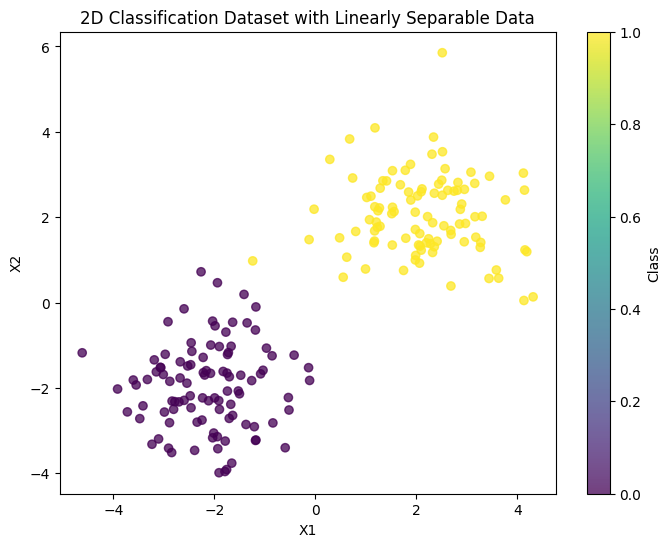

In [65]:
def make_linearly_separable_data(n_samples=200, seed=42):
    np.random.seed(seed)
    n_samples_per_class = n_samples // 2
    X0 = np.random.randn(n_samples_per_class, 2) + np.array([-2, -2])
    X1 = np.random.randn(n_samples - n_samples_per_class, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.array([0] * n_samples_per_class + [1] * (n_samples - n_samples_per_class))
    perm = np.random.permutation(n_samples)
    return X[perm], y[perm]

X, y = make_linearly_separable_data()
visualise_data(X, y, "Linearly Separable Data")

#### 6.2 "Two Moons" Data
---

The two moons dataset introduces a non-linear structure by generating two crescent-shaped clusters. This is moderately more challenging than a simple linearly separable dataset. The curved boundaries of the moons require the network to capture more complex decision surfaces. This challenges the model’s ability to use its hidden layers effectively. It is well known as a benchmark for testing non-linear classification.

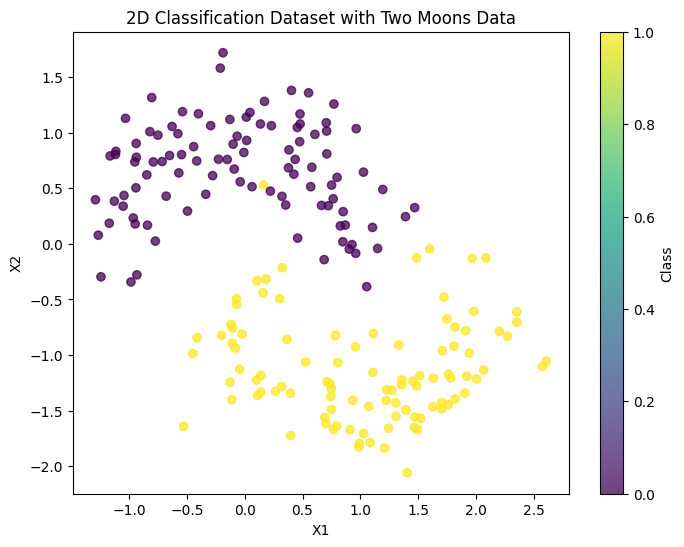

In [68]:
def make_two_moons_data(n_samples=200, noise=0.30, seed=42):
    np.random.seed(seed)
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    angles1 = np.linspace(0, np.pi, n_samples_out)
    angles2 = np.linspace(0, np.pi, n_samples_in)
    
    # First moon (upper crescent)
    X1 = np.vstack([np.cos(angles1), np.sin(angles1)]).T
    # Second moon (lower crescent), shifted appropriately
    X2 = np.vstack([1 - np.cos(angles2), -np.sin(angles2) - 0.5]).T
    
    # Adding noise to both moons
    X1 += noise * np.random.randn(*X1.shape)
    X2 += noise * np.random.randn(*X2.shape)
    
    X = np.vstack([X1, X2])
    y = np.array([0] * n_samples_out + [1] * n_samples_in)
    perm = np.random.permutation(n_samples)
    return X[perm], y[perm]

X, y = make_two_moons_data()
visualise_data(X, y, "Two Moons Data")

#### 6.3 Interleaved Spirals
---

A synthetic 2D classification dataset consisting of two interleaved spirals. I went for spirals since they provide a non-linearly separable dataset, challenging the network to learn complex decision boundaries. For each class, the radius increases linearly and the angle is computed to generate a spiral. A low noise factor (0.05) is added to ensure the dataset is not too noisy while still being realistic.

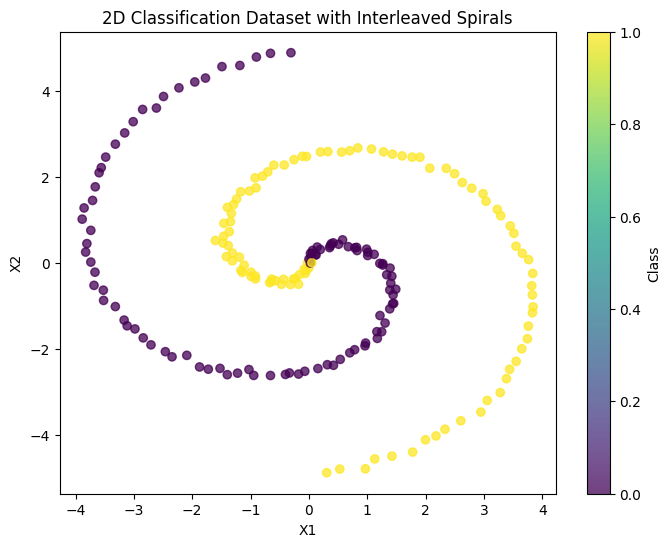

In [71]:
def make_classification_data(n_samples=200, seed=42):
    """
    Generates a 2D synthetic classification dataset with two interleaved spirals.
    This version is *less challenging* than the original by reducing the noise
    and lowering the number of rotations in the spiral.
    """
    np.random.seed(seed)

    n_class0 = n_samples // 2
    n_class1 = n_samples - n_class0

    X = []
    y = []

    for i in range(n_class0):
        r = 5.0 * (i / n_class0)
        theta = 1.0 * (i / n_class0) * 2 * np.pi
        x_coord = r * np.sin(theta) + np.random.randn() * 0.05
        y_coord = r * np.cos(theta) + np.random.randn() * 0.05

        X.append([x_coord, y_coord])
        y.append(0)

    for i in range(n_class1):
        r = 5.0 * (i / n_class1)
        theta = 1.0 * (i / n_class1) * 2 * np.pi + np.pi
        x_coord = r * np.sin(theta) + np.random.randn() * 0.05
        y_coord = r * np.cos(theta) + np.random.randn() * 0.05

        X.append([x_coord, y_coord])
        y.append(1)

    X = np.array(X)
    y = np.array(y)

    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

X, y = make_classification_data()
visualise_data(X, y, "Interleaved Spirals")

## 7. Training Demonstration

Plot functions for visualisation

In [74]:
def plot_history(loss_history: List[float], acc_history: List[float], title: str):
    epochs = np.arange(1, len(loss_history) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, label="Accuracy", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [75]:
def plot_history_on_axes(ax_loss, ax_acc, loss_history: List[float], acc_history: List[float], title: str):
    epochs = np.arange(1, len(loss_history) + 1)
    ax_loss.plot(epochs, loss_history, label="Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_title(f"{title} - Loss over Epochs")
    ax_loss.legend()

    ax_acc.plot(epochs, acc_history, label="Accuracy", color="orange")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_title(f"{title} - Accuracy over Epochs")
    ax_acc.legend()

In [76]:
def plot_compare(loss_history1, acc_history1, loss_history2, acc_history2, loss_history3, acc_history3):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
                        
    plot_history_on_axes(axes[0, 0], axes[0, 1], loss_history1, acc_history1, "ElementWiseFFN")
    plot_history_on_axes(axes[1, 0], axes[1, 1], loss_history2, acc_history2, "MatrixFFN")
    plot_history_on_axes(axes[2, 0], axes[2, 1], loss_history3, acc_history3, "MultiLayerFFN")
    
    plt.tight_layout()
    plt.show()

Auxiliary Lists For Comparison Later:

In [78]:
elementwise_loss_h = []
elementwise_acc_h = []
matrix_loss_h = []
matrix_acc_h = []
multi_loss_h = []
multi_acc_h = []

#### 7.1 Training for Elementwise FFN

In [80]:
def train_elementwise_ffn(elementwise_loss_h, elementwise_acc_h, dataset):
    print("\n===== ElementWiseFFN Training =====")
    if(dataset == "Linearly Separable Data"):
        X, y = make_linearly_separable_data(n_samples=300)
    elif(dataset == "Two Moons Data"):
        X, y = make_two_moons_data(n_samples=300)
    elif(dataset == "Interleaved Spirals"):
        X, y = make_classification_data(n_samples=300)
    else:
        logger.info("ERROR: Dataset Not Recognised!!!")

    model = ElementWiseFFN()
    loss_history = []
    acc_history = []
    loss = []
    rows = []

    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    def forward_batch_fn(X_batch: np.ndarray) -> np.ndarray:
        return model.forward_batch(X_batch)

    def compute_loss_grad(X_batch: np.ndarray, y_batch: np.ndarray) -> Tuple[float, List[float]]:
        y_pred = forward_batch_fn(X_batch)
        loss_val = binary_cross_entropy_loss(y_batch, y_pred)
        dL_dy = binary_cross_entropy_deriv(y_batch, y_pred)
    
        d_w1 = d_w2 = d_w3 = d_w4 = d_w5 = d_w6 = 0.0
        d_b1 = d_b2 = d_b3 = 0.0
    
        for i in range(len(X_batch)):
            x_i = X_batch[i]
            dL_dy_i = dL_dy[i]
    
            sum_h1 = model.w1 * x_i[0] + model.w2 * x_i[1] + model.b1
            h1 = sigmoid(sum_h1)
            sum_h2 = model.w3 * x_i[0] + model.w4 * x_i[1] + model.b2
            h2 = sigmoid(sum_h2)
            sum_o1 = model.w5 * h1 + model.w6 * h2 + model.b3
            o1 = sigmoid(sum_o1)
    
            d_ypred_d_sum_o1 = sigmoid_deriv(sum_o1)
            dL_d_sum_o1 = dL_dy_i * d_ypred_d_sum_o1
    
            d_w5 += dL_d_sum_o1 * h1
            d_w6 += dL_d_sum_o1 * h2
            d_b3 += dL_d_sum_o1
    
            dL_d_h1 = dL_d_sum_o1 * model.w5
            dL_d_h2 = dL_d_sum_o1 * model.w6
    
            d_h1_d_sum_h1 = sigmoid_deriv(sum_h1)
            dL_d_sum_h1 = dL_d_h1 * d_h1_d_sum_h1
            d_w1 += dL_d_sum_h1 * x_i[0]
            d_w2 += dL_d_sum_h1 * x_i[1]
            d_b1 += dL_d_sum_h1

            d_h2_d_sum_h2 = sigmoid_deriv(sum_h2)
            dL_d_sum_h2 = dL_d_h2 * d_h2_d_sum_h2
            d_w3 += dL_d_sum_h2 * x_i[0]
            d_w4 += dL_d_sum_h2 * x_i[1]
            d_b2 += dL_d_sum_h2
    
        bs = len(X_batch)
        grads = [
            d_w1 / bs, d_w2 / bs, d_w3 / bs, d_w4 / bs, d_w5 / bs, d_w6 / bs,
            d_b1 / bs, d_b2 / bs, d_b3 / bs
        ]
        return loss_val, grads


    optimiser = Adam(lr=0.05)
    n_epochs = 1000
    batch_size = 10
    
    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            loss_val, grads = compute_loss_grad(X_batch, y_batch)
            model.update_parameters(grads, optimiser.lr)
        y_pred_full = model.forward_batch(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label == y)
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        if (epoch + 1) % 100 == 0:
            ep, ls, ac = rows[-1]
            print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
            print(header)

    elementwise_loss_h[:] = loss_history
    elementwise_acc_h[:] = acc_history
    plot_history(loss_history, acc_history, "ElementWiseFFN")

#### 7.2 Training for MatrixFFN

In [82]:
def train_matrix_ffn(matrix_loss_h, matrix_acc_h, dataset):
    print("\n===== MatrixFFN Training =====")
    if(dataset == "Linearly Separable Data"):
        X, y = make_linearly_separable_data(n_samples=300)
    elif(dataset == "Two Moons Data"):
        X, y = make_two_moons_data(n_samples=300)
    elif(dataset == "Interleaved Spirals"):
        X, y = make_classification_data(n_samples=300)
    else:
        logger.info("ERROR: Dataset Not Recognised!!!")
    y = y.reshape(-1, 1)

    model = MatrixFFN(D_in=2, H=4, D_out=1, activation='relu')
    loss_history = []
    acc_history = []
    rows = []

    optimiser = SGDWithMomentum(lr=0.01, momentum=0.9)

    n_epochs = 1000
    batch_size = 20
    
    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            y_pred = model.forward(X_batch)
            loss_val = binary_cross_entropy_loss(y_batch, y_pred)
            dL_dy_pred = binary_cross_entropy_deriv(y_batch, y_pred)

            z1 = X_batch.dot(model.W1) + model.b1
            if model.act == relu:
                h = relu(z1)
            else:
                h = sigmoid(z1)

            z2 = h.dot(model.W2) + model.b2
            s2 = sigmoid(z2)

            d_sig = s2 * (1.0 - s2)
            dL_dz2 = dL_dy_pred * d_sig

            grad_W2 = h.T.dot(dL_dz2)
            grad_b2 = np.sum(dL_dz2, axis=0)

            dL_dh = dL_dz2.dot(model.W2.T)
            if model.act == relu:
                d_relu = relu_deriv(z1)
                dL_dz1 = dL_dh * d_relu
            else:
                d_sig1 = sigmoid_deriv(z1)
                dL_dz1 = dL_dh * d_sig1

            grad_W1 = X_batch.T.dot(dL_dz1)
            grad_b1 = np.sum(dL_dz1, axis=0)

            grads = [grad_W1, grad_b1, grad_W2, grad_b2]
            optimiser.step(model.parameters(), grads)

        y_pred_full = model.forward(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label.flatten() == y.flatten())
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        if (epoch + 1) % 100 == 0:
            ep, ls, ac = rows[-1]
            print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
            print(header)

    matrix_loss_h[:] = loss_history
    matrix_acc_h[:] = acc_history
    plot_history(loss_history, acc_history, "MatrixFFN")

#### 7.3 Training for MultiLayerFFN

In [84]:
def train_multi_layer_ffn(multi_loss_h, multi_acc_h, dataset):
    print("\n===== MultiLayerFFN Training =====")
    if(dataset == "Linearly Separable Data"):
        X, y = make_linearly_separable_data(n_samples=300)
    elif(dataset == "Two Moons Data"):
        X, y = make_two_moons_data(n_samples=300)
    elif(dataset == "Interleaved Spirals"):
        X, y = make_classification_data(n_samples=300)
    else:
        logger.info("ERROR: Dataset Not Recognised!!!")
    y = y.reshape(-1, 1)
    layers_config = [
        {"in": 2, "out": 5, "activation": "relu"},
        {"in": 5, "out": 3, "activation": "relu"},
        {"in": 3, "out": 1, "activation": "sigmoid"}
    ]
    model = MultiLayerFFN(layers_config)
    loss_history = []
    acc_history = []
    rows = []

    optimiser = Adam(lr=0.01)

    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    def forward_detailed(X_batch: np.ndarray):
        z_vals = []
        a_vals = []
        a_in = X_batch
        for layer in model.layers:
            W, b, act = layer["W"], layer["b"], layer["act"]
            z = a_in.dot(W) + b
            a_out = act(z)
            z_vals.append(z)
            a_vals.append(a_out)
            a_in = a_out
        return z_vals, a_vals

    def backprop(X_batch: np.ndarray, y_batch: np.ndarray) -> Tuple[float, List[np.ndarray]]:
        z_vals, a_vals = forward_detailed(X_batch)
        y_pred = a_vals[-1]
        loss_val = binary_cross_entropy_loss(y_batch, y_pred)
        dL_dy = binary_cross_entropy_deriv(y_batch, y_pred)
        grads_W = [None] * len(model.layers)
        grads_b = [None] * len(model.layers)
        dA = dL_dy
        for i in reversed(range(len(model.layers))):
            layer = model.layers[i]
            W, b, act, act_deriv = layer["W"], layer["b"], layer["act"], layer["act_deriv"]
            z = z_vals[i]
            A_in = X_batch if i == 0 else a_vals[i - 1]
            dZ = dA * act_deriv(z)
            gradW = A_in.T.dot(dZ)
            gradb = np.sum(dZ, axis=0)
            grads_W[i] = gradW
            grads_b[i] = gradb
            dA = dZ.dot(W.T)
        grads = []
        for gw, gb in zip(grads_W, grads_b):
            grads.append(gw)
            grads.append(gb)
        return loss_val, grads

    n_epochs = 1000
    batch_size = 25

    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            loss_val, grads = backprop(X_batch, y_batch)
            optimiser.step(model.parameters(), grads)
        y_pred_full = model.forward(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label.flatten() == y.flatten())
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        if (epoch + 1) % 100 == 0:
            ep, ls, ac = rows[-1]
            print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
            print(header)
        
    multi_loss_h[:] = loss_history
    multi_acc_h[:] = acc_history
    plot_history(loss_history, acc_history, "MultiLayerFFN")

## 8. Main Execution

#### 8.1 Comparison for Linearly Separable Data

Now we run all three models to see how they fare in a linearly separable dataset

In [88]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


===== ElementWiseFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.1686 |   0.9967 |
+-------+----------+----------+
|   200 |   0.1032 |   0.9967 |
+-------+----------+----------+
|   300 |   0.0736 |   0.9967 |
+-------+----------+----------+
|   400 |   0.0571 |   0.9967 |
+-------+----------+----------+
|   500 |   0.0465 |   0.9967 |
+-------+----------+----------+
|   600 |   0.0393 |   0.9967 |
+-------+----------+----------+
|   700 |   0.0339 |   1.0000 |
+-------+----------+----------+
|   800 |   0.0299 |   1.0000 |
+-------+----------+----------+
|   900 |   0.0267 |   1.0000 |
+-------+----------+----------+
|  1000 |   0.0241 |   1.0000 |
+-------+----------+----------+


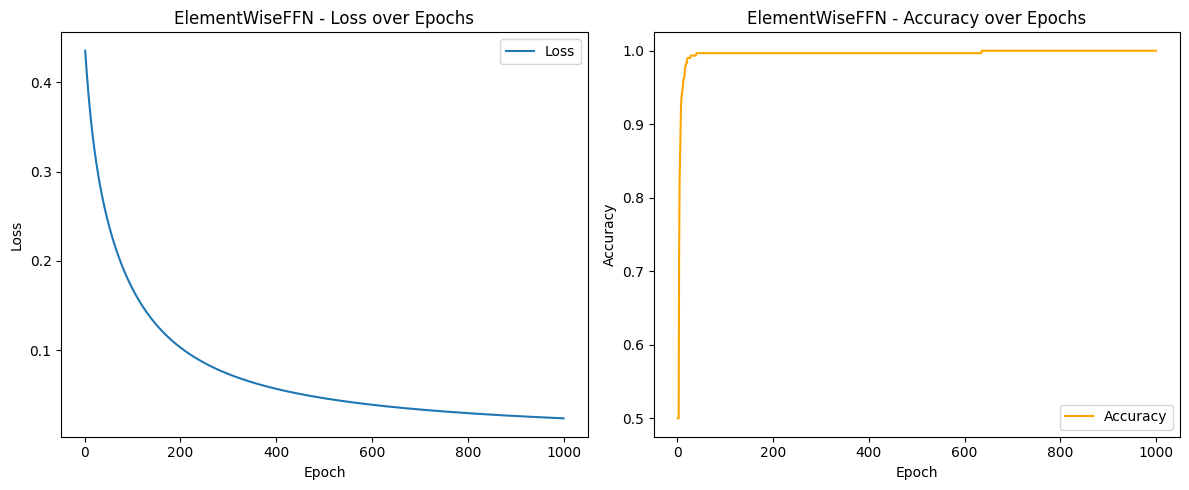

In [89]:
train_elementwise_ffn(elementwise_loss_h, elementwise_acc_h, "Linearly Separable Data")


===== MatrixFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.0106 |   1.0000 |
+-------+----------+----------+
|   200 |   0.0053 |   1.0000 |
+-------+----------+----------+
|   300 |   0.0035 |   1.0000 |
+-------+----------+----------+
|   400 |   0.0026 |   1.0000 |
+-------+----------+----------+
|   500 |   0.0021 |   1.0000 |
+-------+----------+----------+
|   600 |   0.0017 |   1.0000 |
+-------+----------+----------+
|   700 |   0.0015 |   1.0000 |
+-------+----------+----------+
|   800 |   0.0013 |   1.0000 |
+-------+----------+----------+
|   900 |   0.0011 |   1.0000 |
+-------+----------+----------+
|  1000 |   0.0010 |   1.0000 |
+-------+----------+----------+


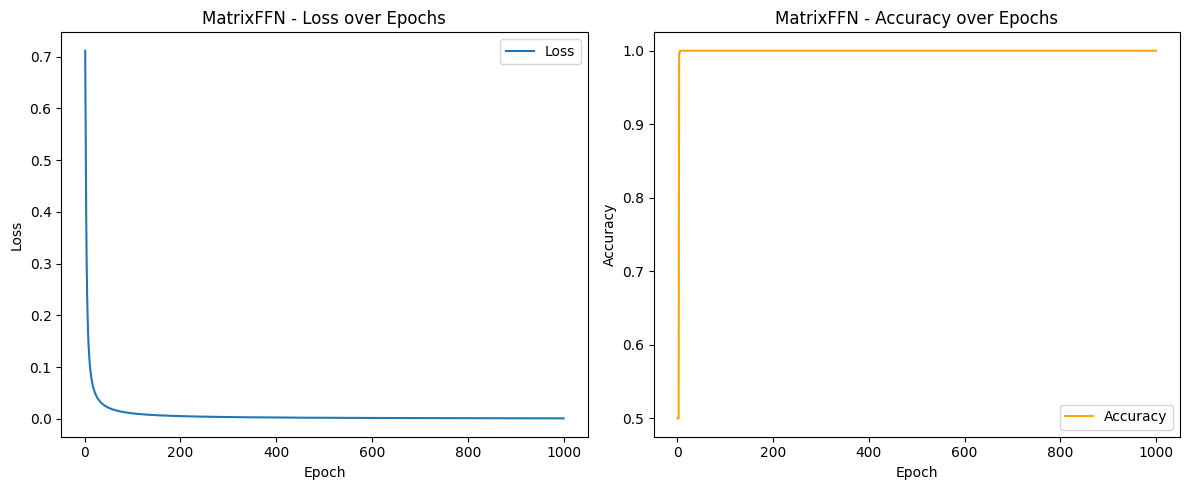

In [90]:
train_matrix_ffn(matrix_loss_h , matrix_acc_h , "Linearly Separable Data")


===== MultiLayerFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.0006 |   1.0000 |
+-------+----------+----------+
|   200 |   0.0002 |   1.0000 |
+-------+----------+----------+
|   300 |   0.0001 |   1.0000 |
+-------+----------+----------+
|   400 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   500 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   600 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   700 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   800 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   900 |   0.0000 |   1.0000 |
+-------+----------+----------+
|  1000 |   0.0000 |   1.0000 |
+-------+----------+----------+


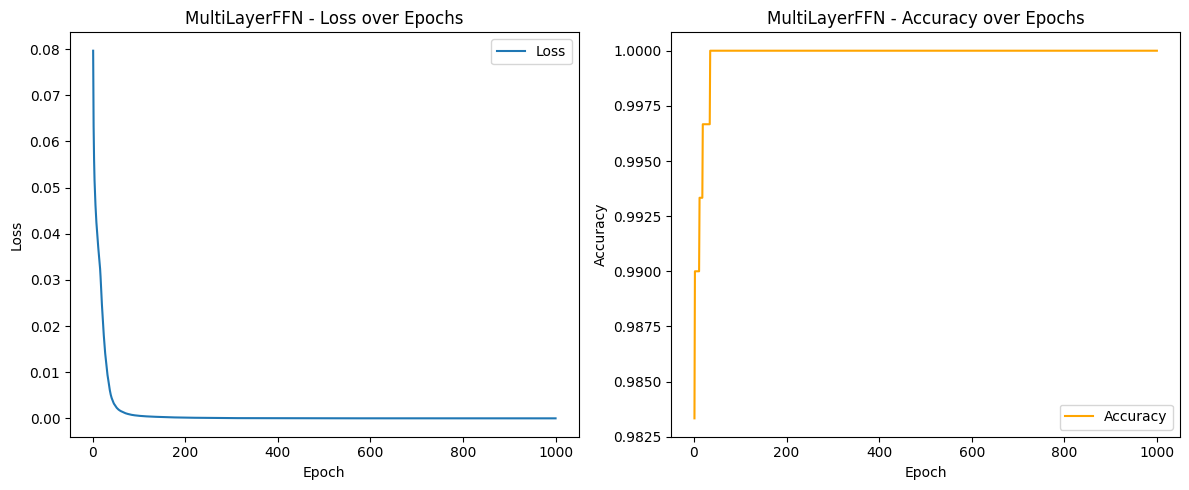

In [91]:
train_multi_layer_ffn(multi_loss_h , multi_acc_h , "Linearly Separable Data")

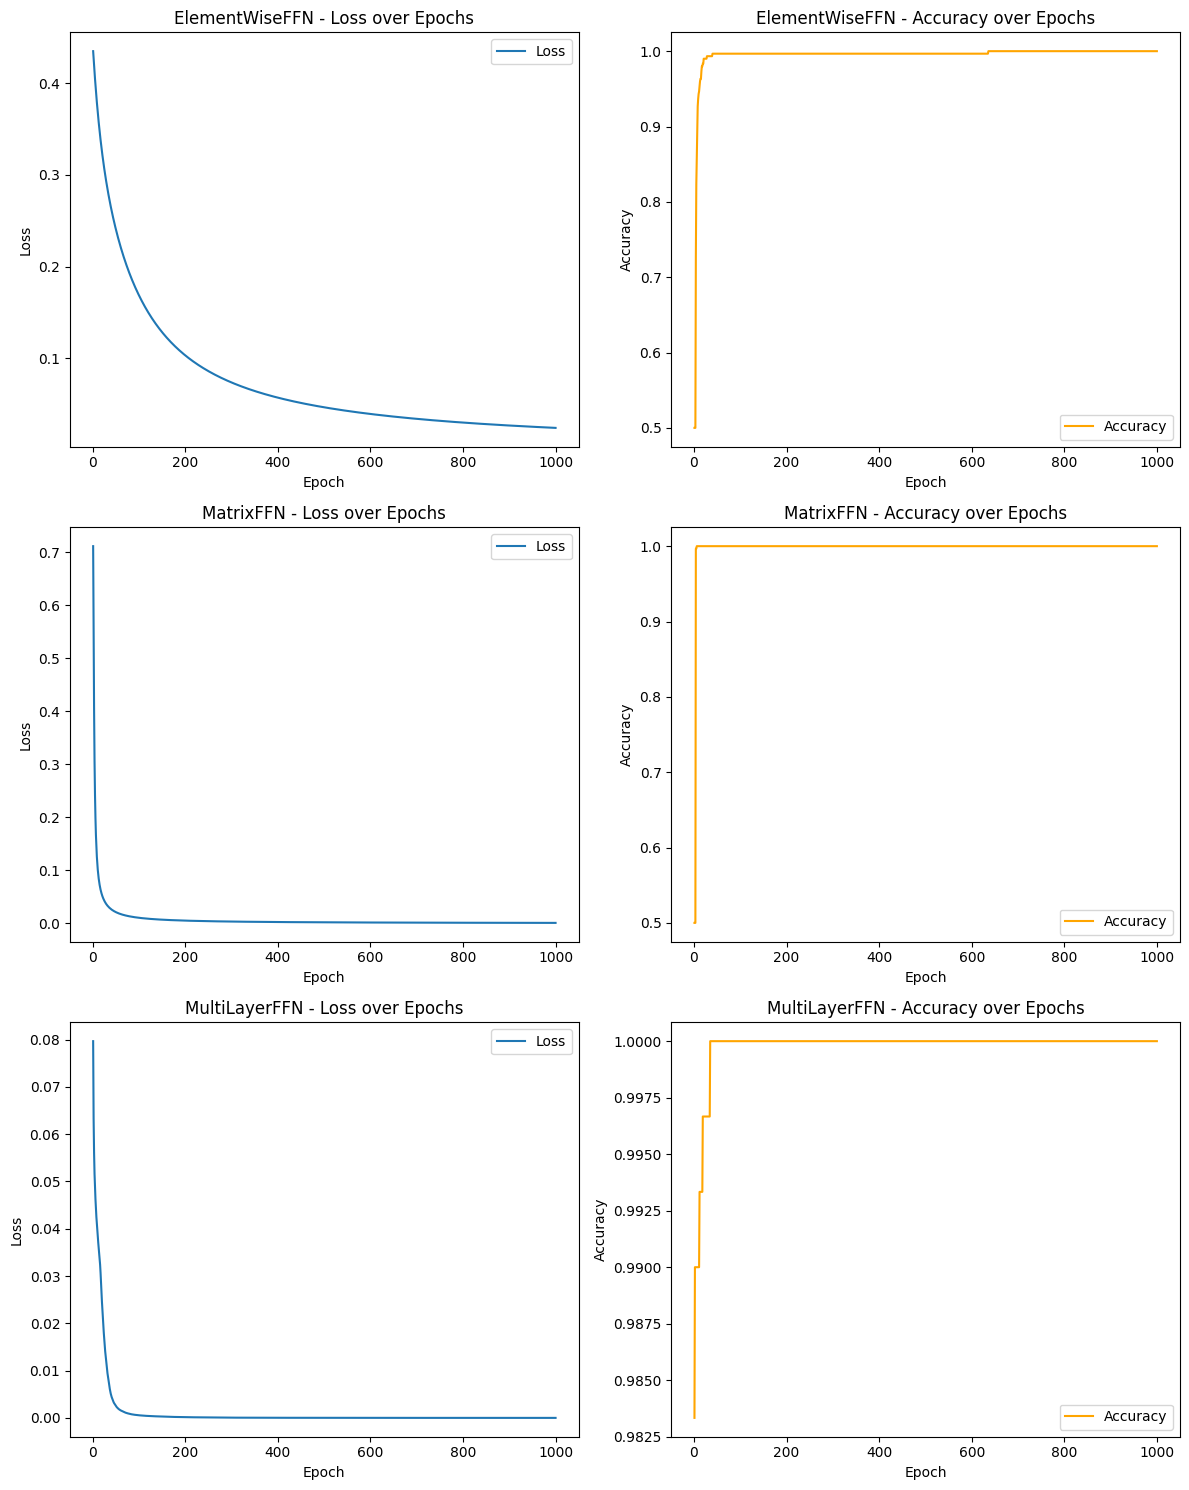

In [92]:
plot_compare(elementwise_loss_h, elementwise_acc_h, matrix_loss_h, matrix_acc_h, multi_loss_h, multi_acc_h)

The data set is relatively straightforward, and all three models are able to reach the maximum accuracy, with MatrixFFN and MultiLayerFFN reaching it within the first 100 epochs. Unsurprisingly the elementwiseFFN reaches the limit the slowest

#### 8.2 Comparison for Two Moons Data

Now we run all three models to see how they fare in a two moons dataset


===== ElementWiseFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.5379 |   0.8700 |
+-------+----------+----------+
|   200 |   0.3156 |   0.9533 |
+-------+----------+----------+
|   300 |   0.1940 |   0.9700 |
+-------+----------+----------+
|   400 |   0.1389 |   0.9767 |
+-------+----------+----------+
|   500 |   0.1105 |   0.9767 |
+-------+----------+----------+
|   600 |   0.0940 |   0.9767 |
+-------+----------+----------+
|   700 |   0.0835 |   0.9733 |
+-------+----------+----------+
|   800 |   0.0764 |   0.9733 |
+-------+----------+----------+
|   900 |   0.0713 |   0.9767 |
+-------+----------+----------+
|  1000 |   0.0675 |   0.9800 |
+-------+----------+----------+


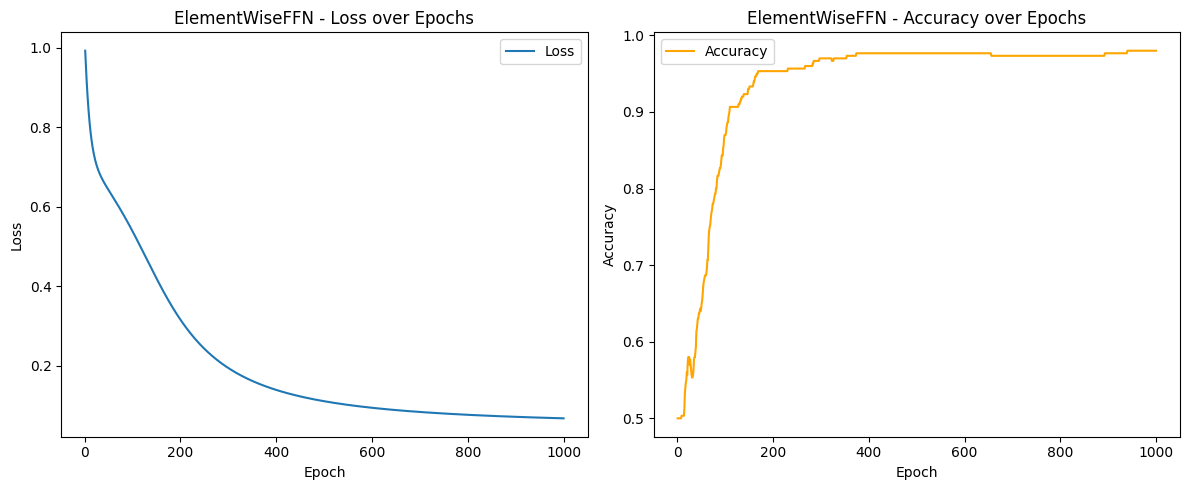

In [96]:
train_elementwise_ffn(elementwise_loss_h, elementwise_acc_h, "Two Moons Data")


===== MatrixFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.0461 |   0.9767 |
+-------+----------+----------+
|   200 |   0.0451 |   0.9800 |
+-------+----------+----------+
|   300 |   0.0447 |   0.9767 |
+-------+----------+----------+
|   400 |   0.0444 |   0.9800 |
+-------+----------+----------+
|   500 |   0.0442 |   0.9767 |
+-------+----------+----------+
|   600 |   0.0440 |   0.9767 |
+-------+----------+----------+
|   700 |   0.0438 |   0.9767 |
+-------+----------+----------+
|   800 |   0.0438 |   0.9767 |
+-------+----------+----------+
|   900 |   0.0438 |   0.9767 |
+-------+----------+----------+
|  1000 |   0.0434 |   0.9800 |
+-------+----------+----------+


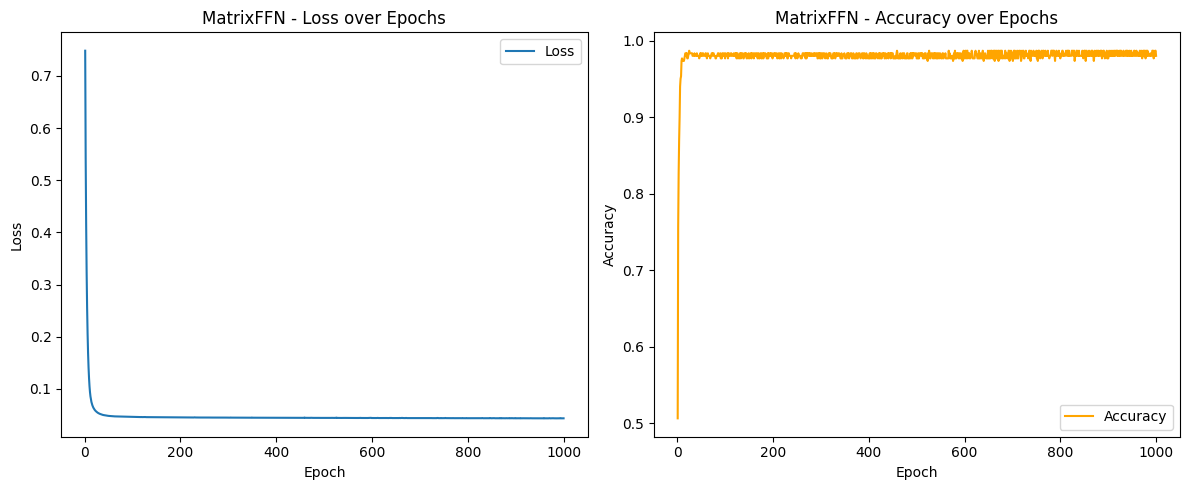

In [97]:
train_matrix_ffn(matrix_loss_h , matrix_acc_h , "Two Moons Data")


===== MultiLayerFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.0166 |   0.9933 |
+-------+----------+----------+
|   200 |   0.0062 |   1.0000 |
+-------+----------+----------+
|   300 |   0.0025 |   1.0000 |
+-------+----------+----------+
|   400 |   0.0010 |   1.0000 |
+-------+----------+----------+
|   500 |   0.0004 |   1.0000 |
+-------+----------+----------+
|   600 |   0.0001 |   1.0000 |
+-------+----------+----------+
|   700 |   0.0001 |   1.0000 |
+-------+----------+----------+
|   800 |   0.0000 |   1.0000 |
+-------+----------+----------+
|   900 |   0.0000 |   1.0000 |
+-------+----------+----------+
|  1000 |   0.0000 |   1.0000 |
+-------+----------+----------+


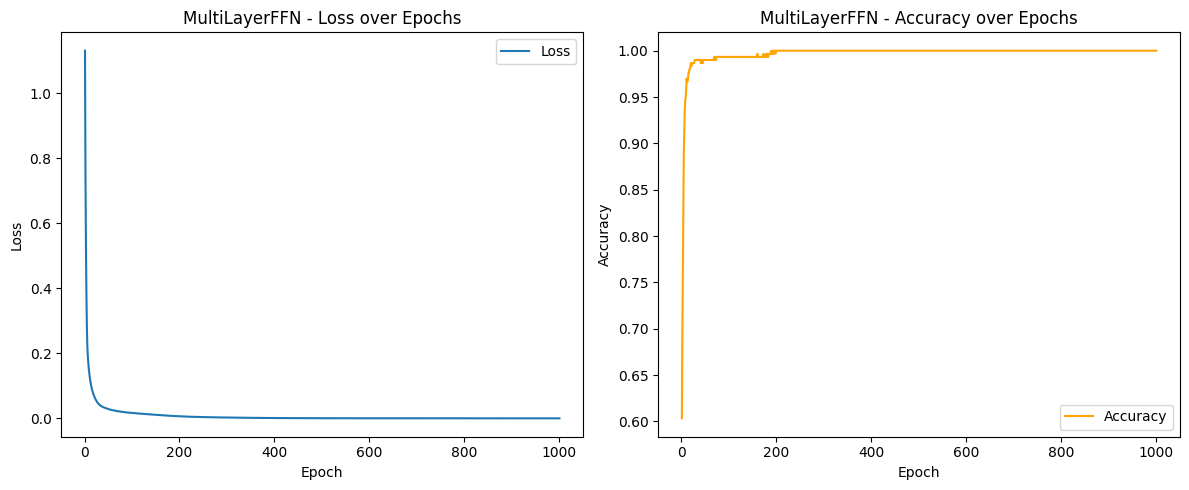

In [98]:
train_multi_layer_ffn(multi_loss_h , multi_acc_h , "Two Moons Data")

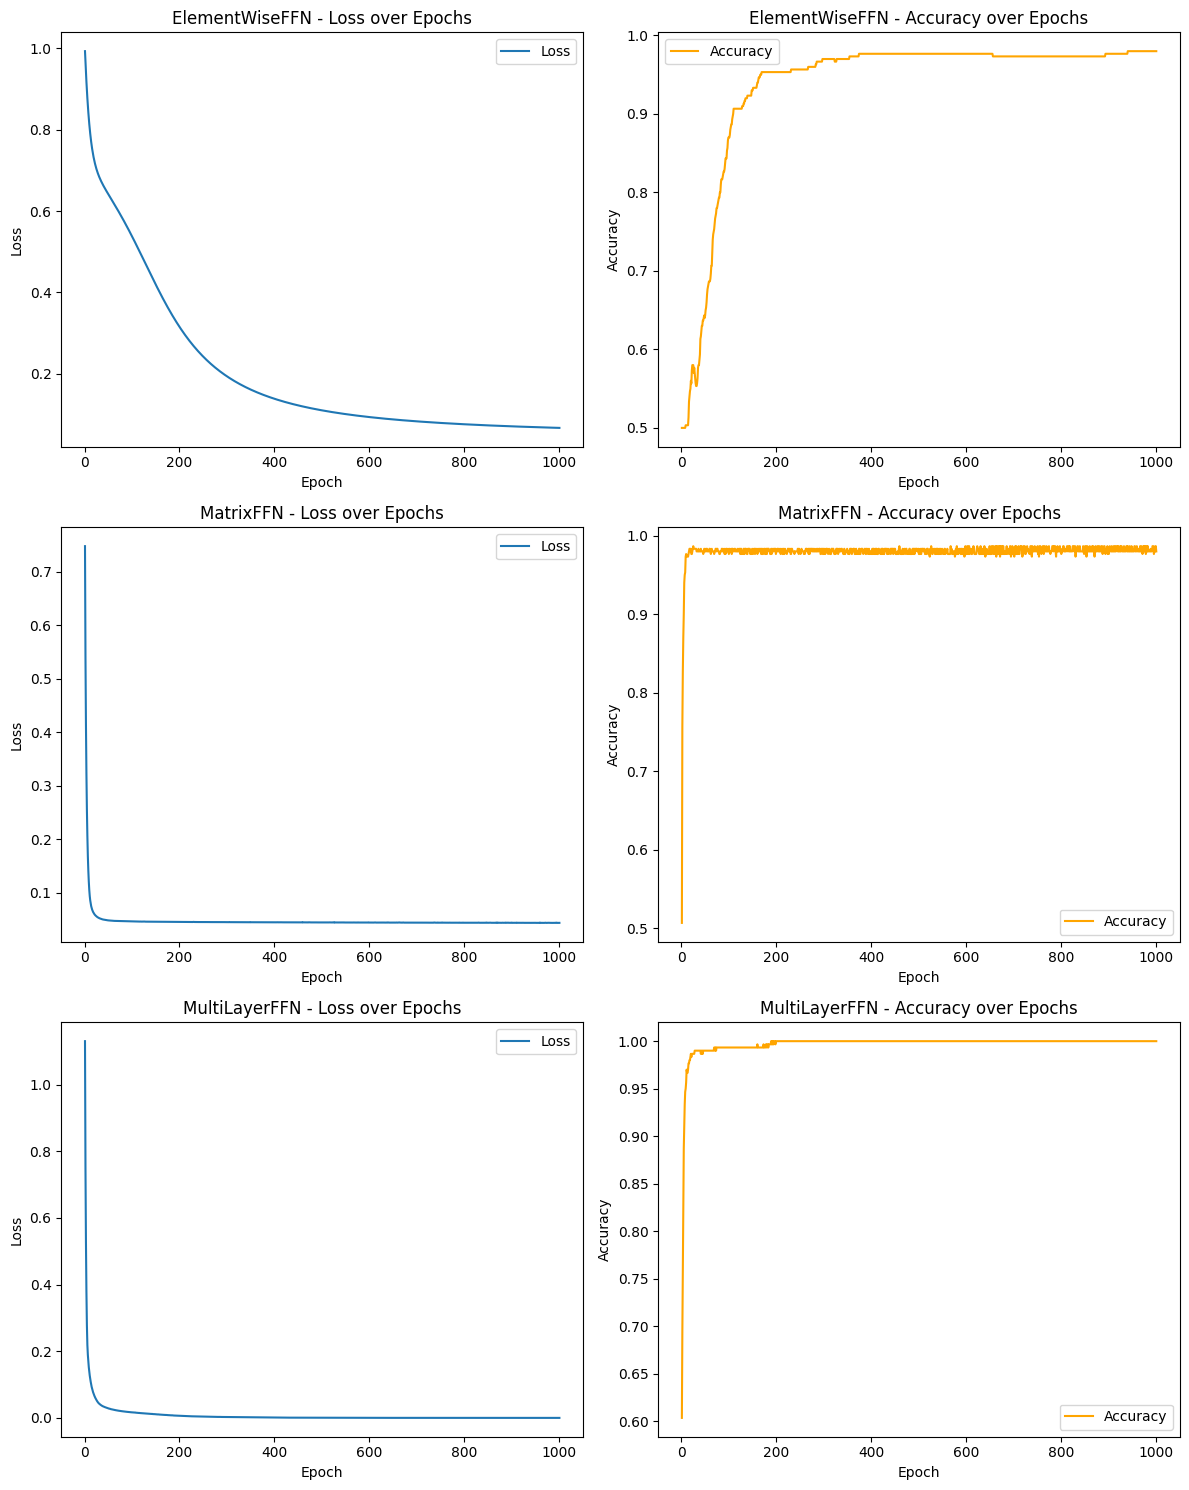

In [99]:
plot_compare(elementwise_loss_h, elementwise_acc_h, matrix_loss_h, matrix_acc_h, multi_loss_h, multi_acc_h)

The observations in the first comparison are more accentuated here, and matrixFFN can also be seen to be a little volatile

#### 8.3 Comparison for Interleaved Spirals Data

Now we run all three models to see how they fare in a interleaved spirals dataset


===== ElementWiseFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.6491 |   0.5100 |
+-------+----------+----------+
|   200 |   0.6401 |   0.5267 |
+-------+----------+----------+
|   300 |   0.6338 |   0.5267 |
+-------+----------+----------+
|   400 |   0.6291 |   0.5333 |
+-------+----------+----------+
|   500 |   0.6253 |   0.5367 |
+-------+----------+----------+
|   600 |   0.6217 |   0.5533 |
+-------+----------+----------+
|   700 |   0.6181 |   0.5667 |
+-------+----------+----------+
|   800 |   0.6144 |   0.5700 |
+-------+----------+----------+
|   900 |   0.6102 |   0.5733 |
+-------+----------+----------+
|  1000 |   0.6056 |   0.5833 |
+-------+----------+----------+


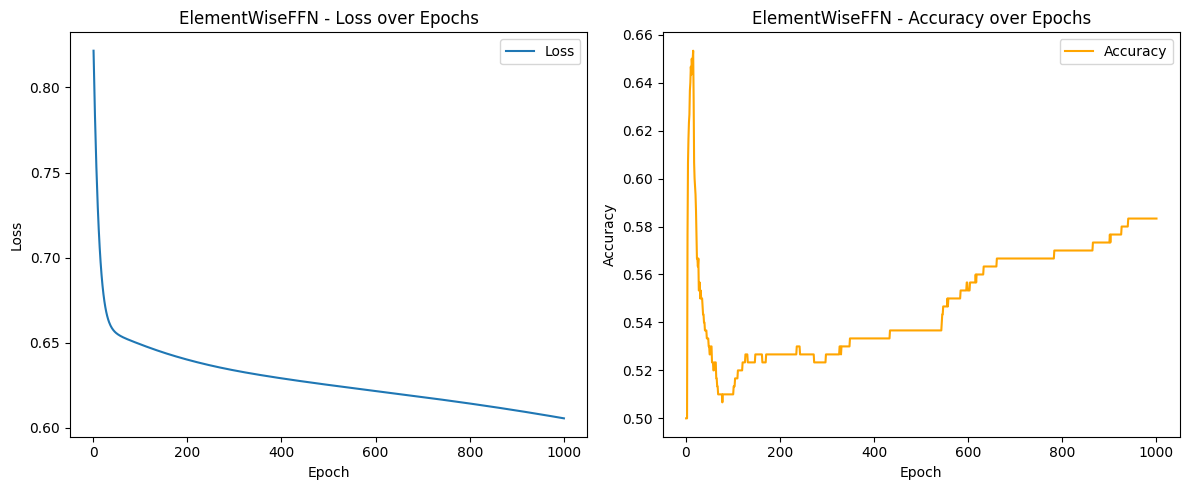

In [103]:
train_elementwise_ffn(elementwise_loss_h, elementwise_acc_h, "Interleaved Spirals")


===== MatrixFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.3961 |   0.8033 |
+-------+----------+----------+
|   200 |   0.2084 |   0.8867 |
+-------+----------+----------+
|   300 |   0.1854 |   0.8833 |
+-------+----------+----------+
|   400 |   0.1797 |   0.8867 |
+-------+----------+----------+
|   500 |   0.1783 |   0.8900 |
+-------+----------+----------+
|   600 |   0.1750 |   0.8900 |
+-------+----------+----------+
|   700 |   0.1743 |   0.8700 |
+-------+----------+----------+
|   800 |   0.1727 |   0.8833 |
+-------+----------+----------+
|   900 |   0.1723 |   0.8767 |
+-------+----------+----------+
|  1000 |   0.1724 |   0.8800 |
+-------+----------+----------+


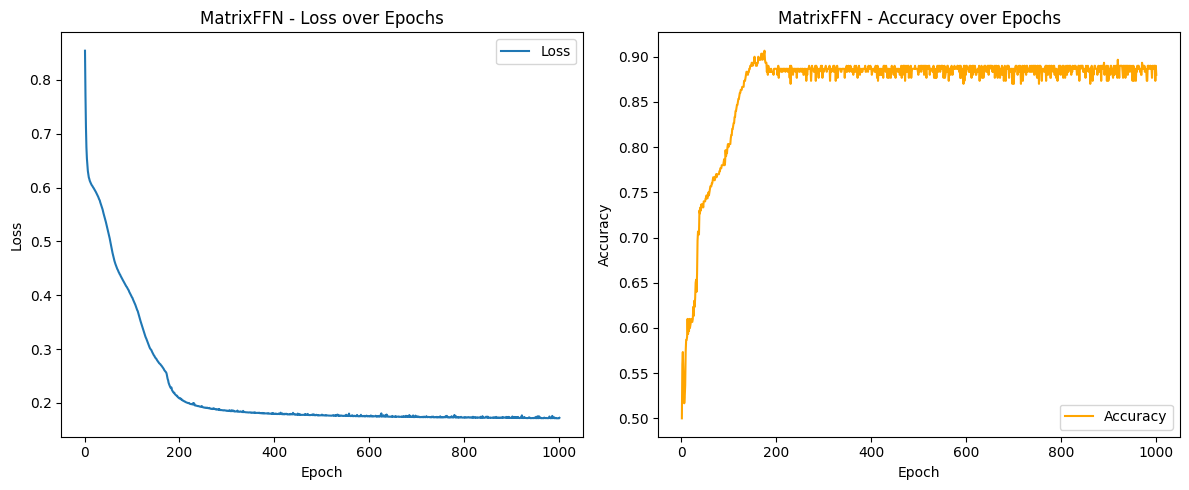

In [104]:
train_matrix_ffn(matrix_loss_h , matrix_acc_h , "Interleaved Spirals")


===== MultiLayerFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|   100 |   0.0267 |   0.9933 |
+-------+----------+----------+
|   200 |   0.0115 |   0.9967 |
+-------+----------+----------+
|   300 |   0.0080 |   0.9967 |
+-------+----------+----------+
|   400 |   0.0070 |   0.9967 |
+-------+----------+----------+
|   500 |   0.0074 |   0.9933 |
+-------+----------+----------+
|   600 |   0.0070 |   0.9933 |
+-------+----------+----------+
|   700 |   0.0067 |   0.9933 |
+-------+----------+----------+
|   800 |   0.0065 |   0.9933 |
+-------+----------+----------+
|   900 |   0.0065 |   0.9967 |
+-------+----------+----------+
|  1000 |   0.0061 |   0.9933 |
+-------+----------+----------+


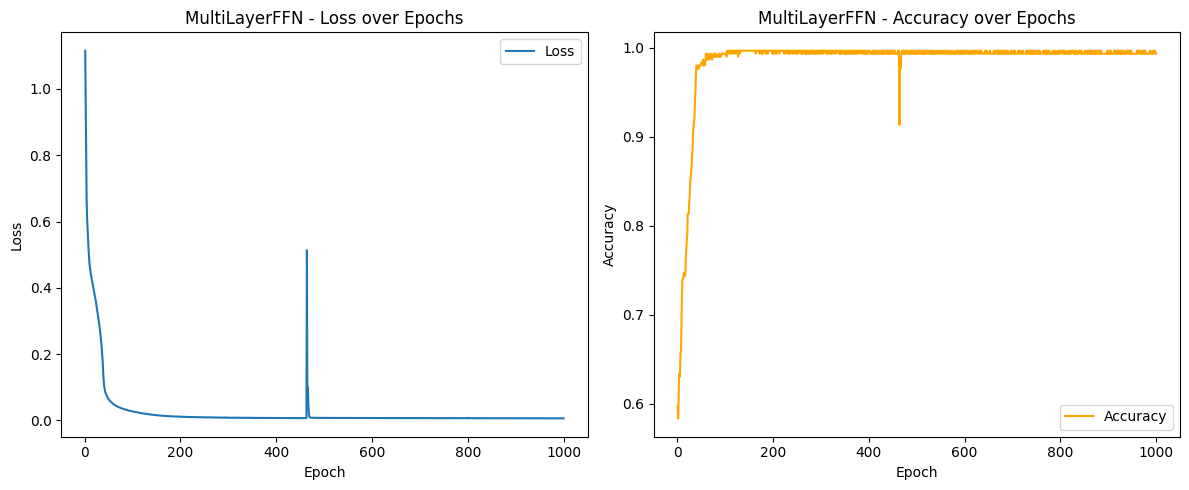

In [105]:
train_multi_layer_ffn(multi_loss_h , multi_acc_h , "Interleaved Spirals")

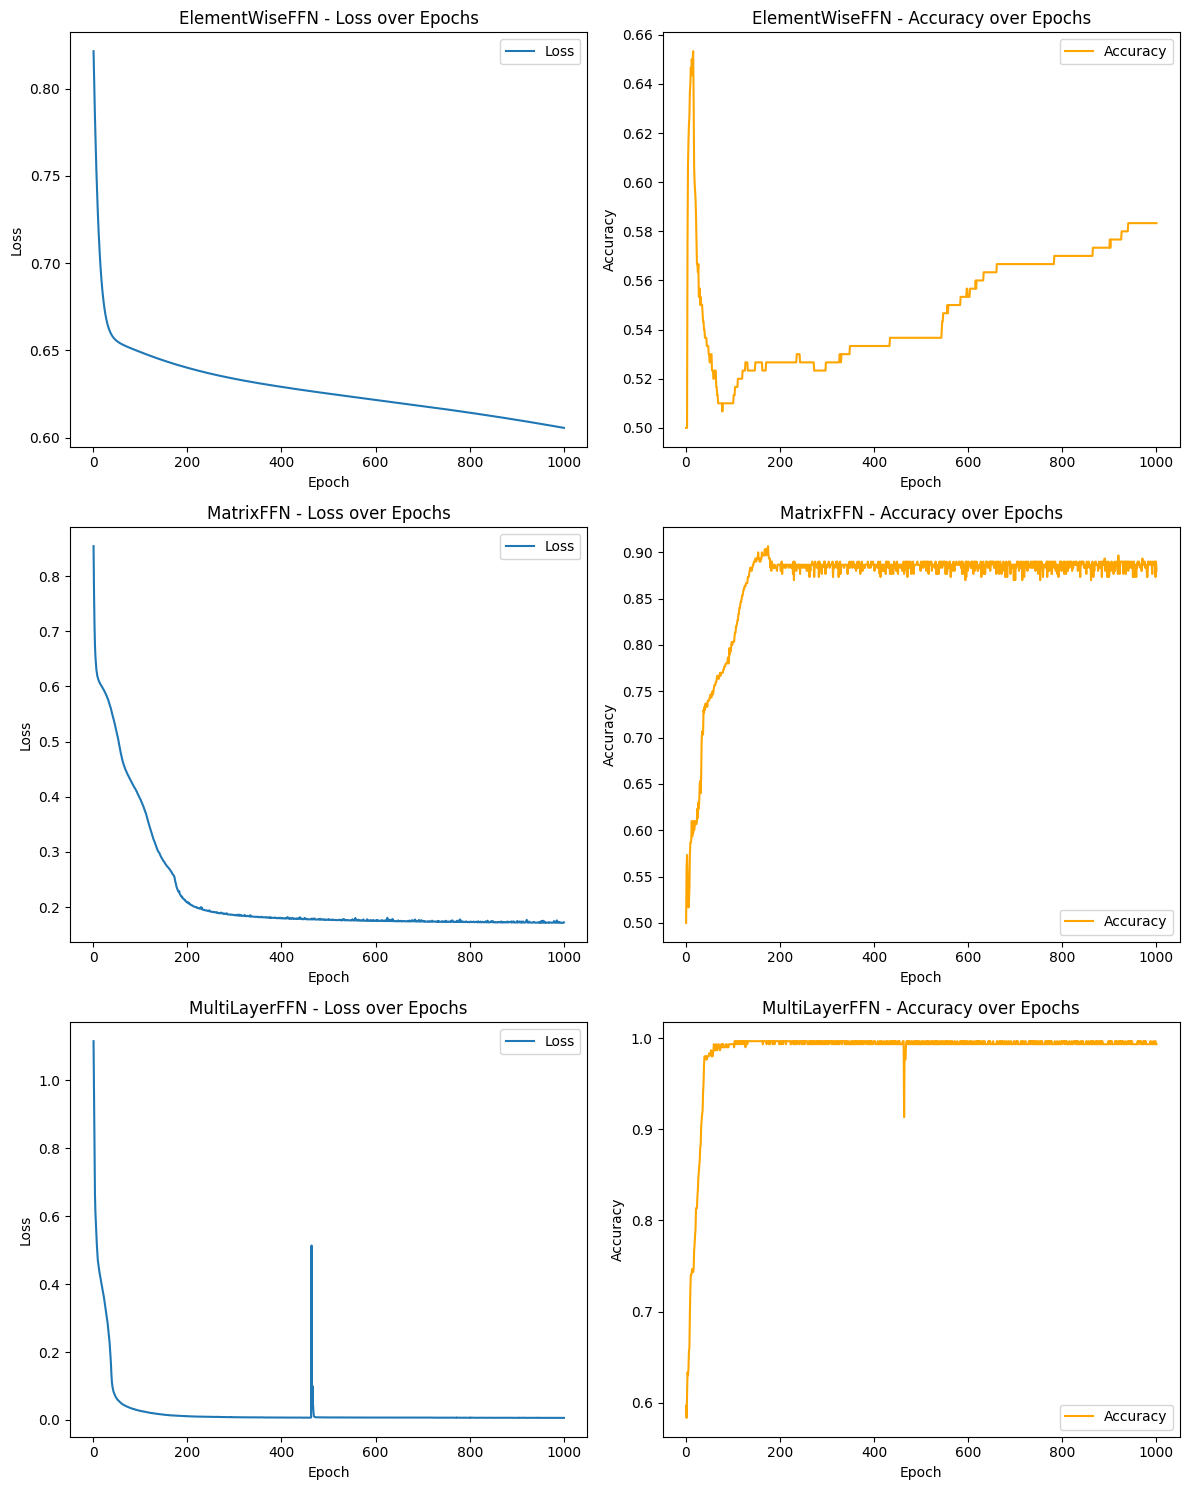

In [106]:
plot_compare(elementwise_loss_h, elementwise_acc_h, matrix_loss_h, matrix_acc_h, multi_loss_h, multi_acc_h)

Once again the results are well within our expectations. However these comparisons are not entirely fair, since these models have different number of hidden layers and neurons, different activation functions and optimisers. From now onwards we will conduct comparisons on the MultiLayerFFN, since it is the most easily extensible and more representative compared to the other two. Additionally the other two were more for experimental implementation purposes.

#### 8.4 Final Comparison

Now we will compare the how different implementations can affect the performance in the different datasets that we have created

In [110]:
def run_comparisons():
    """
    Systematically compares different activation functions, loss functions,
    and optimisers using the MultiLayerFFN on multiple datasets, progressing
    from easiest to hardest.
    """
    dataset_list = [
        ("Linear", make_linearly_separable_data),
        ("TwoMoons", make_two_moons_data),
        ("Spiral", make_classification_data),
    ]

    hidden_activations = ['relu', 'sigmoid']
    losses = [
        ('BCE', binary_cross_entropy_loss, binary_cross_entropy_deriv),
        ('MSE', mse_loss, mse_deriv),
    ]
    optimisers = [
        ('SGD', SGD(lr=0.01)),
        ('Momentum', SGDWithMomentum(lr=0.01, momentum=0.9)),
        ('Adam', Adam(lr=0.01))
    ]
    
    def forward_and_backprop(model: MultiLayerFFN,
                             X_batch: np.ndarray,
                             y_batch: np.ndarray,
                             loss_fn, loss_deriv):
        z_vals = []
        a_vals = []
        a_in = X_batch
        for layer in model.layers:
            W, b, act = layer["W"], layer["b"], layer["act"]
            z = a_in.dot(W) + b
            a_out = act(z)
            z_vals.append(z)
            a_vals.append(a_out)
            a_in = a_out

        y_pred = a_vals[-1]
        loss_val = loss_fn(y_batch, y_pred)

        dL_dy = loss_deriv(y_batch, y_pred)

        grads_W = [None] * len(model.layers)
        grads_b = [None] * len(model.layers)
        dA = dL_dy
        for i in reversed(range(len(model.layers))):
            layer = model.layers[i]
            W, b, act, act_deriv = layer["W"], layer["b"], layer["act"], layer["act_deriv"]
            z = z_vals[i]
            A_in = X_batch if i == 0 else a_vals[i - 1]
            dZ = dA * act_deriv(z)
            gradW = A_in.T.dot(dZ)
            gradb = np.sum(dZ, axis=0)
            grads_W[i] = gradW
            grads_b[i] = gradb
            dA = dZ.dot(W.T)

        grads = []
        for gw, gb in zip(grads_W, grads_b):
            grads.append(gw)
            grads.append(gb)
        return loss_val, grads

    comparison_results = []

    for dataset_name, dataset_fn in dataset_list:
        X, y = dataset_fn(n_samples=300)
        y = y.reshape(-1, 1)
        for hidden_act in hidden_activations:
            layers_config = [
                {"in": 2, "out": 5, "activation": hidden_act},
                {"in": 5, "out": 1, "activation": "sigmoid"}
            ]
            for loss_name, loss_fn, loss_deriv in losses:
                for opt_name, opt_obj in optimisers:
                    model = MultiLayerFFN(layers_config)
                    if opt_name == 'SGD':
                        optimiser_instance = SGD(lr=opt_obj.lr)
                    elif opt_name == 'Momentum':
                        optimiser_instance = SGDWithMomentum(lr=opt_obj.lr, momentum=opt_obj.momentum)
                    else:
                        optimiser_instance = Adam(lr=opt_obj.lr, beta1=opt_obj.beta1, beta2=opt_obj.beta2, eps=opt_obj.eps)

                    n_epochs = 1000
                    batch_size = 25
                    loss_history = []
                    acc_history = []

                    for epoch in range(n_epochs):
                        perm = np.random.permutation(len(X))
                        X_epoch = X[perm]
                        y_epoch = y[perm]
                        for i in range(0, len(X_epoch), batch_size):
                            X_batch = X_epoch[i:i + batch_size]
                            y_batch = y_epoch[i:i + batch_size]
                            loss_val, grads = forward_and_backprop(model, X_batch, y_batch, loss_fn, loss_deriv)
                            optimiser_instance.step(model.parameters(), grads)
                        y_pred_full = model.forward(X)
                        epoch_loss = loss_fn(y, y_pred_full)
                        preds_label = (y_pred_full >= 0.5).astype(int)
                        epoch_acc = np.mean(preds_label.flatten() == y.flatten())
                        loss_history.append(epoch_loss)
                        acc_history.append(epoch_acc)

                    final_loss = loss_history[-1]
                    final_acc = acc_history[-1]
                    comparison_results.append({
                        'Dataset': dataset_name,
                        'HiddenAct': hidden_act,
                        'LossFn': loss_name,
                        'Optimiser': opt_name,
                        'FinalLoss': final_loss,
                        'FinalAccuracy': final_acc,
                        'LossHistory': loss_history,
                        'AccHistory': acc_history
                    })

    df = pd.DataFrame(comparison_results)
    datasets = df['Dataset'].unique()
    losses_list = df['LossFn'].unique()
    optimisers_list = df['Optimiser'].unique()

    for ds in datasets:
        for loss_fn in losses_list:
            sub_df = df[(df['Dataset'] == ds) & (df['LossFn'] == loss_fn)]
            fig, ax = plt.subplots(figsize=(8, 6))
            width = 0.35
            x = np.arange(len(optimisers_list))
            acc_relu = []
            acc_sigmoid = []
            for opt in optimisers_list:
                row_relu = sub_df[(sub_df['Optimiser'] == opt) & (sub_df['HiddenAct'] == 'relu')]
                row_sigmoid = sub_df[(sub_df['Optimiser'] == opt) & (sub_df['HiddenAct'] == 'sigmoid')]
                acc_relu.append(row_relu['FinalAccuracy'].values[0] if not row_relu.empty else 0)
                acc_sigmoid.append(row_sigmoid['FinalAccuracy'].values[0] if not row_sigmoid.empty else 0)
            ax.bar(x - width/2, acc_relu, width, label='ReLU')
            ax.bar(x + width/2, acc_sigmoid, width, label='Sigmoid')
            ax.set_xticks(x)
            ax.set_xticklabels(optimisers_list)
            ax.set_xlabel('Optimiser')
            ax.set_ylabel('Final Accuracy')
            ax.set_title(f'{ds} - {loss_fn} - Final Accuracy')
            ax.legend()
            plt.tight_layout()
            plt.show()

            fig, ax = plt.subplots(figsize=(8, 6))
            loss_relu = []
            loss_sigmoid = []
            for opt in optimisers_list:
                row_relu = sub_df[(sub_df['Optimiser'] == opt) & (sub_df['HiddenAct'] == 'relu')]
                row_sigmoid = sub_df[(sub_df['Optimiser'] == opt) & (sub_df['HiddenAct'] == 'sigmoid')]
                loss_relu.append(row_relu['FinalLoss'].values[0] if not row_relu.empty else 0)
                loss_sigmoid.append(row_sigmoid['FinalLoss'].values[0] if not row_sigmoid.empty else 0)
            ax.bar(x - width/2, loss_relu, width, label='ReLU')
            ax.bar(x + width/2, loss_sigmoid, width, label='Sigmoid')
            ax.set_xticks(x)
            ax.set_xticklabels(optimisers_list)
            ax.set_xlabel('Optimiser')
            ax.set_ylabel('Final Loss')
            ax.set_title(f'{ds} - {loss_fn} - Final Loss')
            ax.legend()
            plt.tight_layout()
            plt.show()

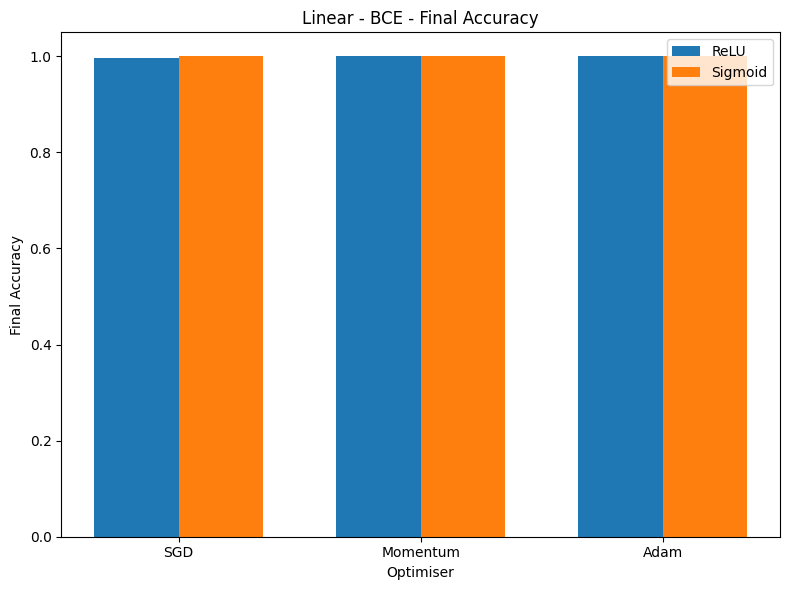

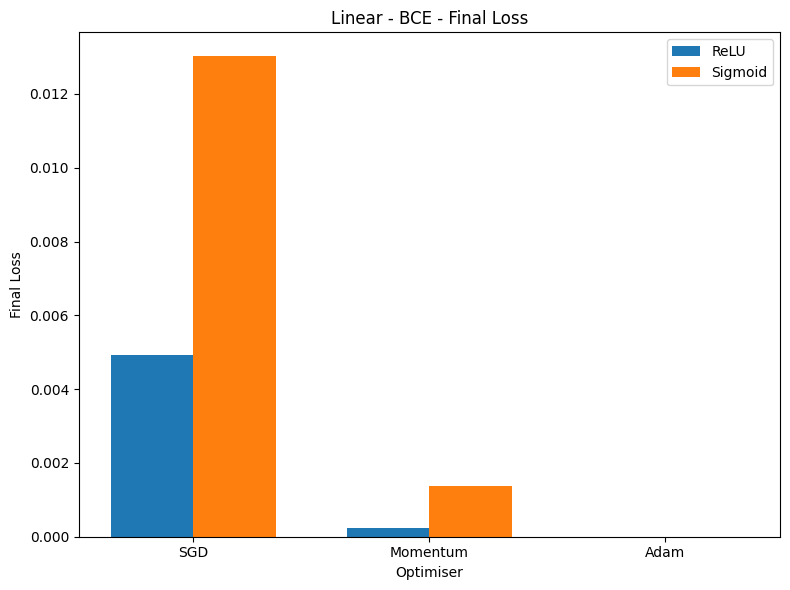

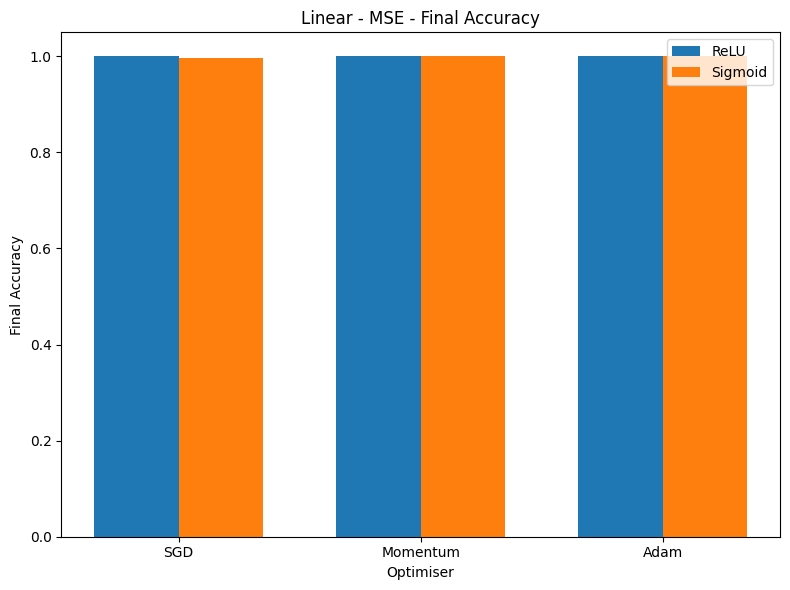

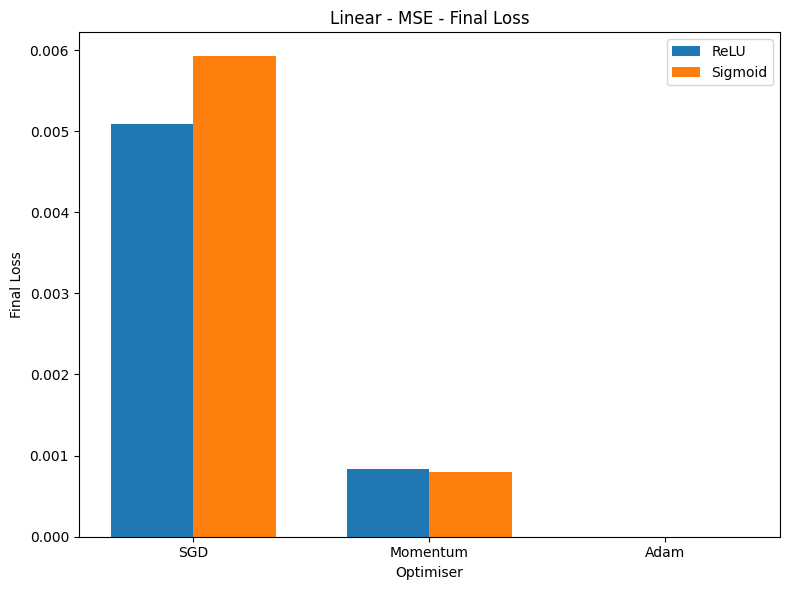

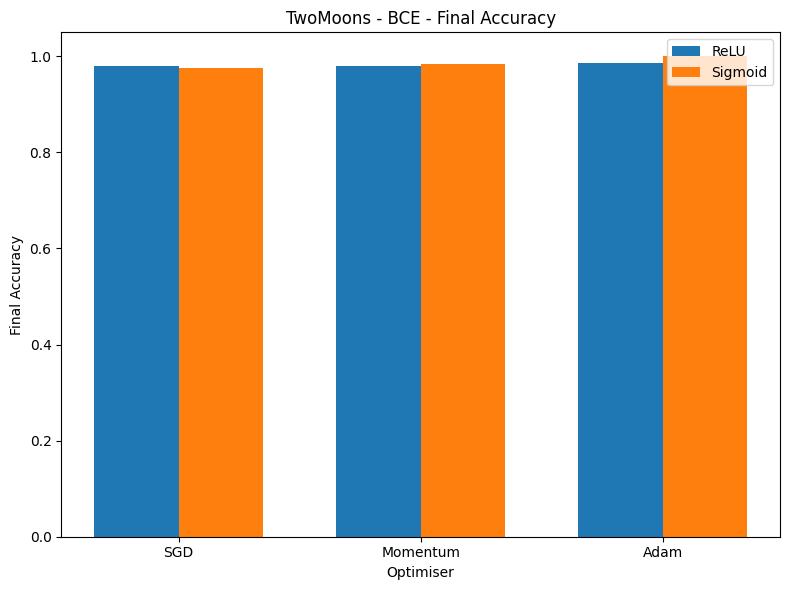

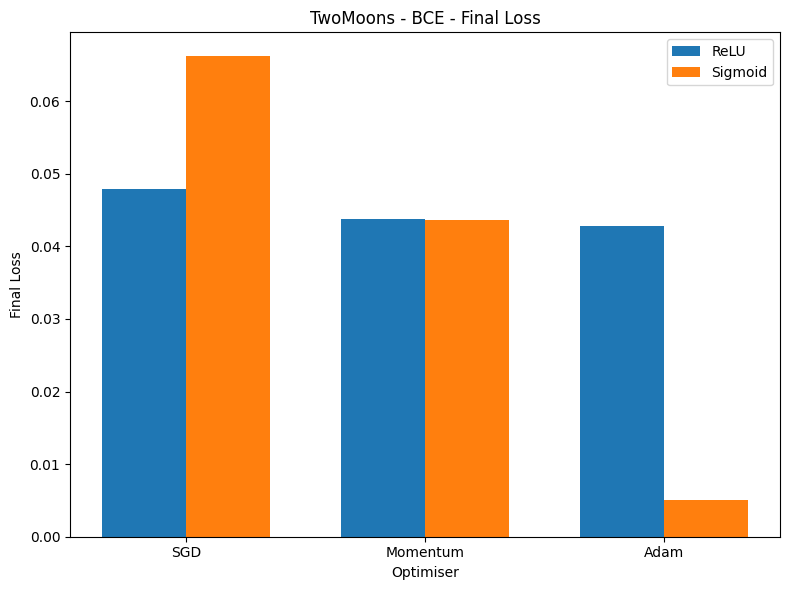

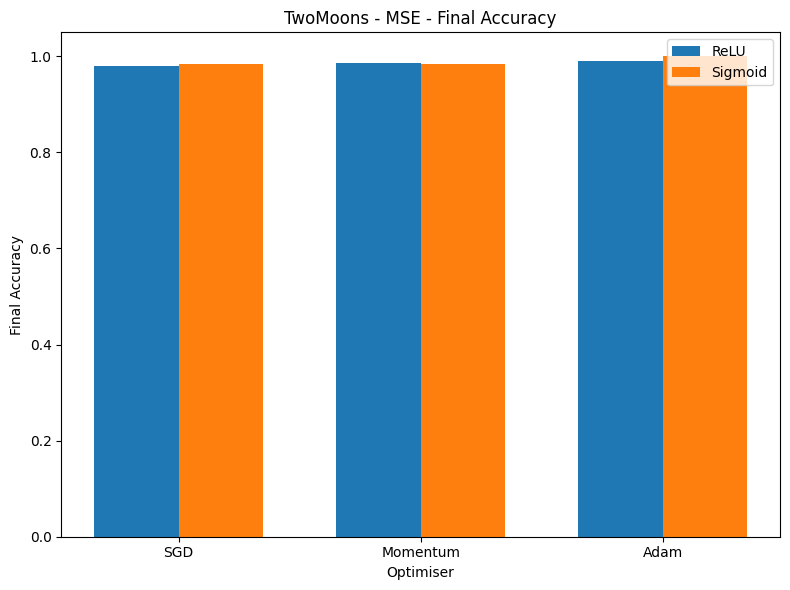

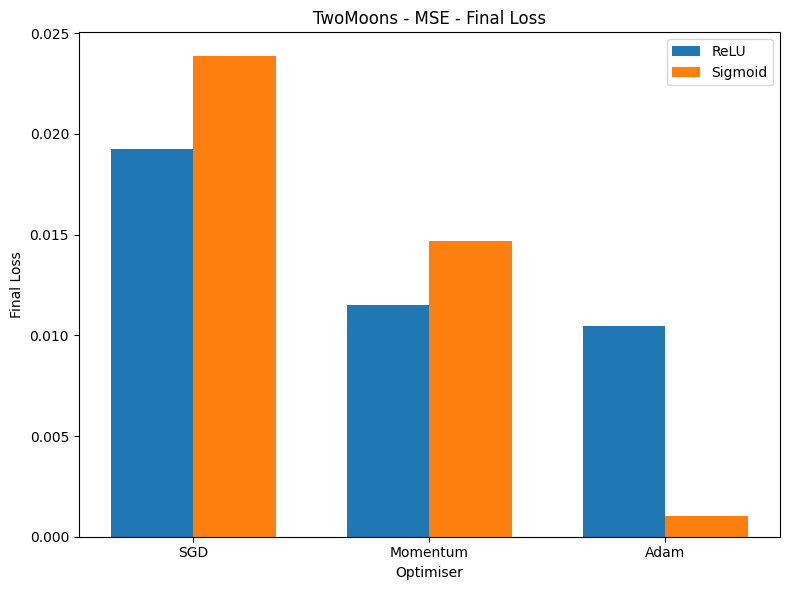

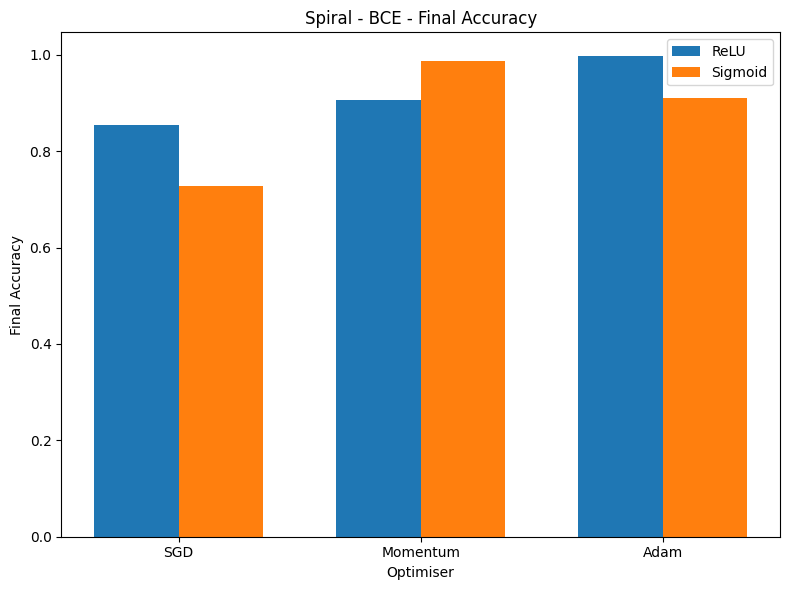

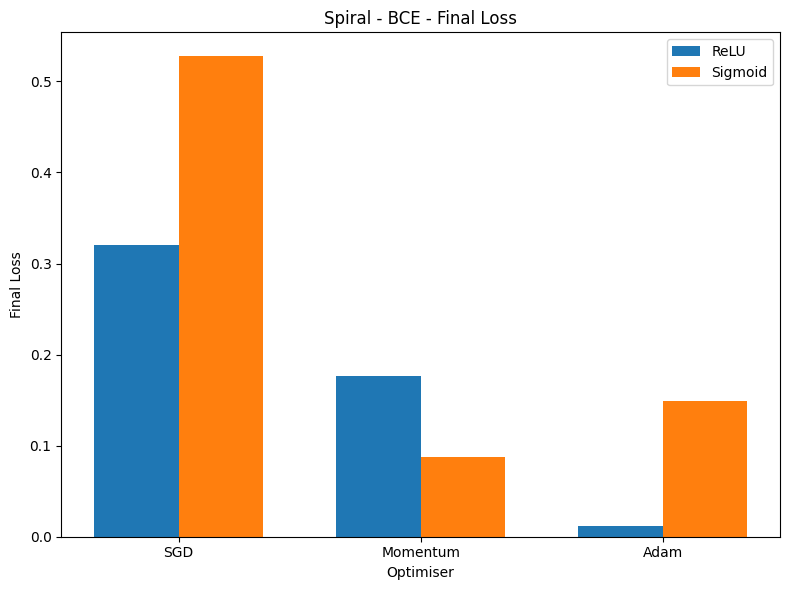

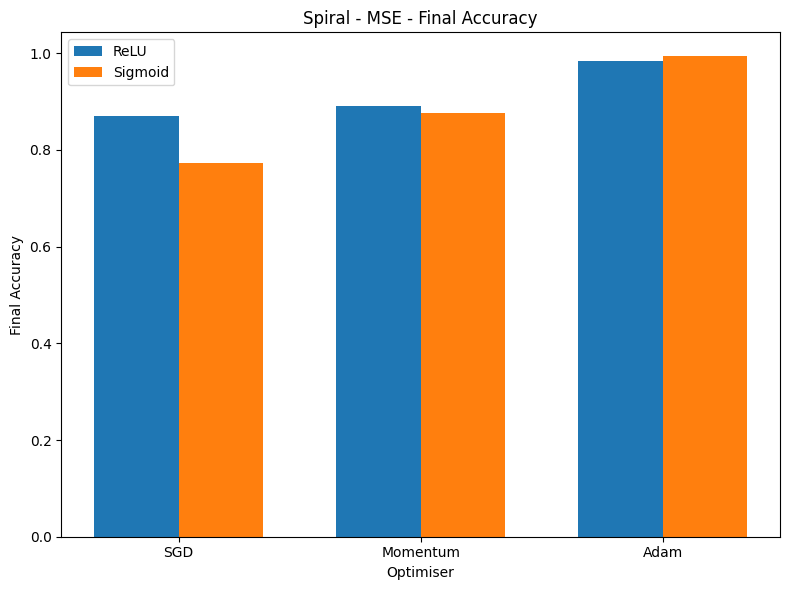

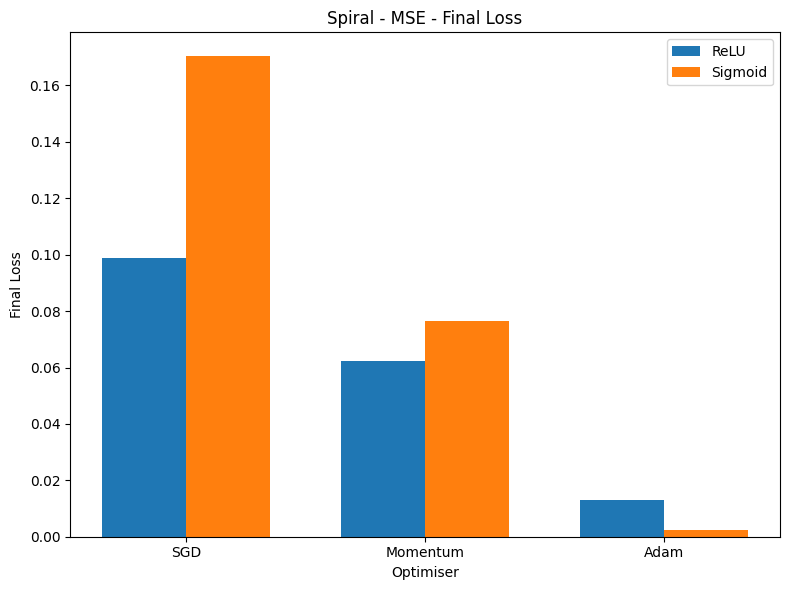

In [111]:
run_comparisons()

## 9. Summary

#### 9.1 Dataset Difficulty

**Linearly Separated Data**

- It is the easiest problem. Since the data is linearly separable, even a single hidden layer of modest size is enough to achieve near‐perfect accuracy
- There are minimal differences in results. All activation functions (ReLU or Sigmoid), loss functions (BCE or MSE), and optimisers (SGD, Momentum, Adam) quickly converge to a good solution. Hence, we see bars near 1.0 accuracy across the board
- Does not tell us much about the differences in performance

**Two Moons Data**

- Has moderate complexity. The decision boundary is nonlinear but still not very complicated. Most configurations can learn it effectively, though training might require slightly more epochs or better hyperparameters
- We see small differences in final accuracy or loss (e.g., Adam vs. plain SGD). Still, the dataset is not so hard that it forces large performance gaps

**Interleaving Spirals**

- Most Challenging of the three. This dataset has a more complex, tightly wound boundary. Networks are more prone to local minima, vanishing/exploding gradients, and other difficulties
- There are greater discrepancies. We see bigger differences among optimisers, losses, and activations—some combinations converge better (e.g., Adam with ReLU), while others might get stuck or converge more slowly (e.g., SGD with Sigmoid)

#### 9.2 Loss Functions Comparison

**Mean Squared Error(MSE)**

- It is less ideal for classification. Although we can still train a classifier with MSE, the gradient signals can be weaker or slower, especially if the output saturates (common with Sigmoid)
- There are performance gaps on hard tasks. On simpler tasks, MSE still does fine; on complex tasks (like Spiral), BCE often edges it out in final accuracy or speed of convergence

**Binary Cross‐Entropy (BCE)** 

- BCE is specifically designed for binary classification, producing stronger gradient signals when outputs are near 0 or 1
- BCE tends to converge faster. Because it directly measures the difference between predicted probabilities and class labels, BCE typically leads to quicker improvements in classification tasks

#### 9.3 Activation Functions Comparison

**Sigmoid**

- Saturates at values near 0 or 1, causing gradients to become very small
- Sufficient for Simple Data: On linear or two‐moons data, the difference may not be huge
- Struggles More on Complex Tasks: The spiral dataset may highlight vanishing‐gradient issues

**ReLu**

- Non‐Saturating for Positive Inputs: ReLU tends to avoid the vanishing‐gradient problem that plagues Sigmoid in deeper layers or more complex tasks
- Faster Convergence: Often trains faster in practice, especially for data that requires complex boundaries
- Potential for “Dead” Neurons: If inputs are mostly negative, ReLU neurons can output zero and stop learning, though in practice it’s still usually quite effective

#### 9.4 Optimisers Comparison

**SGD with No Momentum**

- Slower Convergence: Tends to require more epochs or careful tuning of the learning rate
- Sufficient for Easy Tasks: You can still reach near‐perfect accuracy on linear or two‐moons data, but you might see bigger differences on the spiral

**SGD with Momentum**

- Faster than Plain SGD: Helps escape shallow minima or plateaus by carrying velocity from previous updates
- Often Outperforms Plain SGD on moderately difficult tasks

**Adam**

- Adaptive Learning Rates: Adjusts per‐parameter learning rates, often speeding convergence and handling ravines or plateaus better
- Shines on Hard Tasks: Typically yields better or more stable performance on the spiral dataset, which is more sensitive to gradient magnitude and direction